In [ ]:
import pandas as pd 
import datetime

cols = ['id', 'host_id', 'host_since', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 
        'neighbourhood_cleansed', 'latitude', 'longitude', 'host_listings_count',
        'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 
        'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 
        'monthly_price', 'security_deposit', 'cleaning_fee', 'guests_included', 
        'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews',
        'first_review', 'last_review', 'review_scores_rating',
        'review_scores_accuracy', 'review_scores_cleanliness',
        'review_scores_checkin', 'review_scores_communication',
        'review_scores_location', 'review_scores_value', 'reviews_per_month']

df = pd.read_csv('paris_airbnb.csv', usecols=cols)

def excel_dt_to_dt(x):
    """Method to be applied to df column of excel dates in day format. 
    Args:
        x - value to be processed

    Returns:
        processed value of x
    """
    try:
        x = datetime.date(1899,12,30) + datetime.timedelta(days=int(x))
    except ValueError:
        x = datetime.date(1899,12,30)
    return x

df['host_since'] = df['host_since'].apply(excel_dt_to_dt)
df['first_review'] = df['first_review'].apply(excel_dt_to_dt)
df['last_review'] = df['last_review'].apply(excel_dt_to_dt)

In [ ]:
# Generate multi-host df
df1 = df[df['host_listings_count'] > 1]
# Generate df of active listings
date_range = [df['last_review'].max()-datetime.timedelta(days=x) for x in range(366)]
df_act = df[df['last_review'].isin(date_range)]
df1_act = df1[df1['last_review'].isin(date_range)]
# Generate df of booked and unbooked listings
df_b = df[df['number_of_reviews'].isin(range(1, df['number_of_reviews'].max()))]
df_ub = df[df['number_of_reviews'].isin([0])]
# Generate subset dfs of people with and without profile pictures & verfication
df_b_pp = df_b[(df_b['host_has_profile_pic'] == 't') & (df_b['host_identity_verified'] == 't')]
df_b_npp = df_b[~((df_b['host_has_profile_pic'] == 't') & (df_b['host_identity_verified'] == 't'))]

df_ub_pp = df_ub[(df_ub['host_has_profile_pic'] == 't') & (df_ub['host_identity_verified'] == 't')]
df_ub_npp = df_ub[~((df_ub['host_has_profile_pic'] == 't') & (df_ub['host_identity_verified'] == 't'))]


In [ ]:
# Find number of multi-hosts
num_mh = df1[df1.duplicated('host_id')]['host_id'].nunique()
# Find number of hosts
num_hosts = df['host_id'].nunique()
# Number of listings
num_list_mh = len(df1)
num_list_tot = len(df)

In [ ]:
# Find average price
avg_prc_tot = df_act['price'].sum()/len(df_act)
avg_prc_mh = df1_act['price'].sum()/len(df1_act)
# Find average price per room
av_rm_tot = avg_prc_tot/df_act['accommodates'].mean()
av_rm_mh = avg_prc_mh/df1_act['accommodates'].mean()
# Find average bookings
avg_book_tot = df_act['number_of_reviews'].sum()/len(df_act)
avg_book_mh = df1_act['number_of_reviews'].sum()/len(df1_act)
# Estimated cash flow
avg_cf_tot = avg_prc_tot*avg_book_tot*len(df_act)
avg_cf_mh = avg_prc_mh*avg_book_mh*len(df1_act)
# Estimated AirBnB revenue, @3% of host and 6% guest
avg_rev_tot = avg_cf_tot*0.03 + avg_cf_tot*0.06
avg_rev_mh = avg_cf_mh*0.03 + avg_cf_mh*0.06

In [ ]:
# % with profile pic and verification
ppv_b = len(df_b_pp)/len(df_b)
ppv_ub = len(df_ub_pp)/len(df_ub)

In [ ]:
# Find average price
avg_prc_ub = df_ub['price'].sum()/len(df_ub)
# Find average bookings
avg_book_ub = 7
# Estimated cash flow
avg_cf_ub = avg_prc_ub*avg_book_ub*len(df_ub)
# Estimated AirBnB revenue, @3% of host and 6% guest
avg_rev_ub = avg_cf_ub*0.03 + avg_cf_ub*0.06

In [ ]:
import wikipedia 
from decimal import getcontext
# wikpedia API returns decimal objects, set precision to 3
getcontext().prec = 3
# Popular destinations taken from: https://upload.wikimedia.org/wikipedia/commons/a/a8/Paris_printable_tourist_attractions_map.jpg
pages = ['Arc de Triomphe', 'Eiffel Tower', 'Champ de Mars', 'Champs-Élysées',
    'Grand Palais', 'Pont Alexandre III', 'Les Invalides', 'Place de la Concorde',
    'Tuileries Garden', 'Musée d\'Orsay', 'Sacré-Cœur, Paris', 'Moulin Rouge', 
    'Galeries Lafayette', 'Palais Garnier', 'Louvre', 'Pont Neuf', 'Sainte-Chapelle',
    'Notre-Dame de Paris', 'University of Paris', 'Panthéon', 'Centre Pompidou',
    'Hôtel de Ville, Paris', 'Place de la Bastille', 'Les Halles']

def parse_page_coords(pages: list) -> dict:
    """Function to parse coordinates from wiki pages.
    Args:
        pages - list of wiki pages to parse

    Returns:
        df-friendly dict format of page coordinates [lat, long]
    """
    attraction_coords = {}
    for page in pages:
        wiki_page = wikipedia.page(title=page)
        attraction_coords.setdefault(page, [])
        try:
            coords = wiki_page.coordinates
            coords = [float(coords[0]), float(coords[1])]
            attraction_coords[page] = coords
        except KeyError:
            # If we can't find the coordinates, we aren't interested
            attraction_coords.pop(page)
    return attraction_coords

attraction_coords = parse_page_coords(pages)

In [ ]:
import importlib
import helpers
importlib.reload(helpers)

neighbourhoods = ['Montparnasse', 'Hotel-de-Ville', 'Menilmontant', 'Rue de Vaugirard', '11th arrondissement',                              'Montmartre', 'Elysee', 'Place du Panthéon', '10th arrondissement', '13th arrondissement', 
                '9th arrondissement', '6th arrondissement', '19th arrondissement', '3rd arrondissement', 
                '1st arrondissement', '7th arrondissement', '12th arrondissement', '2nd arrondissement', 
                '17th arrondissement', '16th arrondissement']

def get_attraction_times(origin: list, dest: dict) -> dict:
    """Get time between Paris neighbourhood and attractions.
    Args:
        origin - list of neighbourhoods
        dest - df-friendly dict format of page coordinates [lat, long]

    Returns:
        times - df-friendly dict format of listing ids and travel times to attractions
    """
    times = {}
    for loc in origin:
        try:
            times.setdefault(loc, [])
            origin_ = helpers.geocode_location(loc)
            for j in dest.keys():
                dest_ = (dest[j][0], dest[j][1])
                distance = helpers.get_distance(origin_, dest_)
                time = helpers.parse_request_data(distance)
                times[loc].append(time)
        except (IndexError, KeyError) as e:
            print(loc)
            print(e)
    return times

times = get_attraction_times(neighbourhoods, attraction_coords)

In [ ]:
# Count the number of attractions within certain transit distance per neighbourhood
nearby_attractions = {}
transit_limit = 1200
for loc in neighbourhoods:
    nearby_attractions.setdefault(loc, sum(num <= transit_limit for num in times[loc]))

In [ ]:
# Find number of active properties in each neighbourhood
def get_neighbourhood_vals(df: "Dataframe") -> dict:
    """Get the number of active listings per region.
    Args:
        df - pandas dataframe of AirBnB listings

    Returns:
        nbhd_vals - dict of reviews and listings for superhosts and total per neighbourhood
            in form {neighbourhood: [active_listings]}
    """
    nbhd_vals = {}
    date_range = [df['last_review'].max()-datetime.timedelta(days=x) for x in range(366)]
    for i in range(len(df)):
        if df['last_review'][i] in date_range:
            nbhd_vals.setdefault(df['neighbourhood_cleansed'][i], 0)
            nbhd_vals[df['neighbourhood_cleansed'][i]] += 1
    return nbhd_vals

nbhd_act = get_neighbourhood_vals(df)

In [ ]:
# Replace nearby attraction neighbourhoods
correct_attractions = {}
correct_attractions['Observatoire'] = nearby_attractions['Montparnasse']
correct_attractions['Buttes-Chaumont'] = nearby_attractions['19th arrondissement']
correct_attractions['H√¥tel-de-Ville'] = nearby_attractions['Hotel-de-Ville']
correct_attractions['Vaugirard'] = nearby_attractions['Rue de Vaugirard']
correct_attractions['Popincourt'] = nearby_attractions['11th arrondissement']
correct_attractions['√âlys√©e'] = nearby_attractions['Elysee']
correct_attractions['Panth√©on'] = nearby_attractions['Place du Panthéon']
correct_attractions['Entrep√¥t'] = nearby_attractions['10th arrondissement']
correct_attractions['Buttes-Montmartre'] = nearby_attractions['Montmartre']
correct_attractions['Gobelins'] = nearby_attractions['13th arrondissement']
correct_attractions['Op√©ra'] = nearby_attractions['9th arrondissement']
correct_attractions['Luxembourg'] = nearby_attractions['6th arrondissement']
correct_attractions['Temple'] = nearby_attractions['3rd arrondissement']
correct_attractions['Louvre'] = nearby_attractions['1st arrondissement']
correct_attractions['Palais-Bourbon'] = nearby_attractions['7th arrondissement']
correct_attractions['Reuilly'] = nearby_attractions['12th arrondissement']
correct_attractions['Bourse'] = nearby_attractions['2nd arrondissement']
correct_attractions['M√©nilmontant'] = nearby_attractions['Menilmontant']
correct_attractions['Batignolles-Monceau'] = nearby_attractions['17th arrondissement']
correct_attractions['Passy'] = nearby_attractions['16th arrondissement']

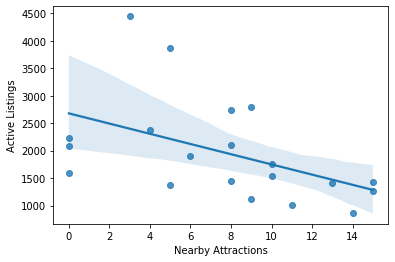

In [71]:
# Convert attraction time and neighbourhood listing dicts to one df
df_attrct = pd.DataFrame.from_dict(correct_attractions, orient='index', columns=['Nearby Attractions'])
df_nbhd_act = pd.DataFrame.from_dict(nbhd_act, orient='index', columns=['Active Listings'])
df_attrct['Neighbourhood'] = df_attrct.index
df_nbhd_act['Neighbourhood'] = df_nbhd_act.index
df_plt = df_nbhd_act.merge(df_attrct, how='left', on='Neighbourhood')

# Plot Number of nearby attractions against active listings
import seaborn as sns
sns.regplot(x='Nearby Attractions', y='Active Listings', data=df_plt, fit_reg=True)